## Práctica 2

In [103]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import random
import shutil

### Se definen funciones generales

In [104]:
def plot_samples_dataset(X, y):

    # Crear la grilla de 4x4
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Grilla de imágenes del dataset Face Mask')

    # Iterar para mostrar 16 imágenes con sus etiquetas de forma aleatoria
    for i, ax in enumerate(axes.flat):
        idx = random.randint(0, len(X) - 1)
        img = X[idx].numpy().reshape(128, 128, 3)
        label = y[idx]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'{label}')
        ax.axis('off')
    plt.show()

def plot_loss_historia_keras(history):
    # Graficar el histórico de pérdida durante el entrenamiento
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

def plot_acc_historia_keras(history):
    # Graficar la precisión durante el entrenamiento
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()


def plot_matriz_confusion(cm, tipo_modelo):
    # Visualizar la matriz de confusión usando Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title(f'Matriz de Confusión para el {tipo_modelo} en el dataset de facemask')
    plt.show()


In [105]:
# Limpiar la sesión de Keras

tf.keras.backend.clear_session()  # <- libera el grafo/sesión previa

# Seteamos la semilla para todo el entorno
seed = 42
random.seed(seed) 
np.random.seed(seed)
tf.random.set_seed(seed)

## Práctica 2

#### Preprocesamiento de las imagenes

A diferencia de la práctica 1, se ajusta el procesamiento previo para que las imagenes las recorte con un margen mayor a las coordenadas clasificadas, ya que las clasificaciones en algunos casos recortaban información útil. Adicionalmente se filtran aquellas imagenes que luego de ser recortadas sean menores a 28x28 para mejorar la calidad del dataset.

In [106]:
base_dir = Path().resolve()

path_images = base_dir / "Dataset" / "images"
path_annotations = base_dir / "Dataset" / "annotations"
path_output = base_dir / "Dataset" / "images_processed"

shutil.rmtree(path_output, ignore_errors=True)
os.makedirs(path_output, exist_ok=True)

for xml_file in os.listdir(path_annotations):
    if not xml_file.endswith(".xml"):
        continue
    
    # Parsear el XML
    xml_path = os.path.join(path_annotations, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Cargar la imagen correspondiente
    nombre_imagen = xml_file.replace(".xml", ".png")
    img_path = os.path.join(path_images, nombre_imagen)
    img = Image.open(img_path)
    
    W, H = img.size
    
    # Recorrer cada objeto etiquetado
    for i, obj in enumerate(root.findall("object")):
        nombre_clase = obj.find("name").text
        
        # Coordenadas
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        
        pad = 0.20
        dx = int((xmax - xmin) * pad)
        dy = int((ymax - ymin) * pad)
        xmin = max(0, xmin - dx)
        ymin = max(0, ymin - dy)
        xmax = min(W, xmax + dx)
        ymax = min(H, ymax + dy)

        # Recortar
        recorte = img.crop((xmin, ymin, xmax, ymax))
        
        # Carpeta por clase
        carpeta_clase = os.path.join(path_output, nombre_clase)
        os.makedirs(carpeta_clase, exist_ok=True)
        
        # Guardar recorte
        recorte.save(os.path.join(carpeta_clase, f"{xml_file[:-4]}_{i}.png"))

#### 1- Preparación y limpieza de datos

A diferencia de la práctica 1 que se utilizó MLP y fue necesario aplanar la imagen. En este caso se va a utilizar CNN que no requiere aplanar la imagen y aprovecha la información de los diferentes canales de la imagen.

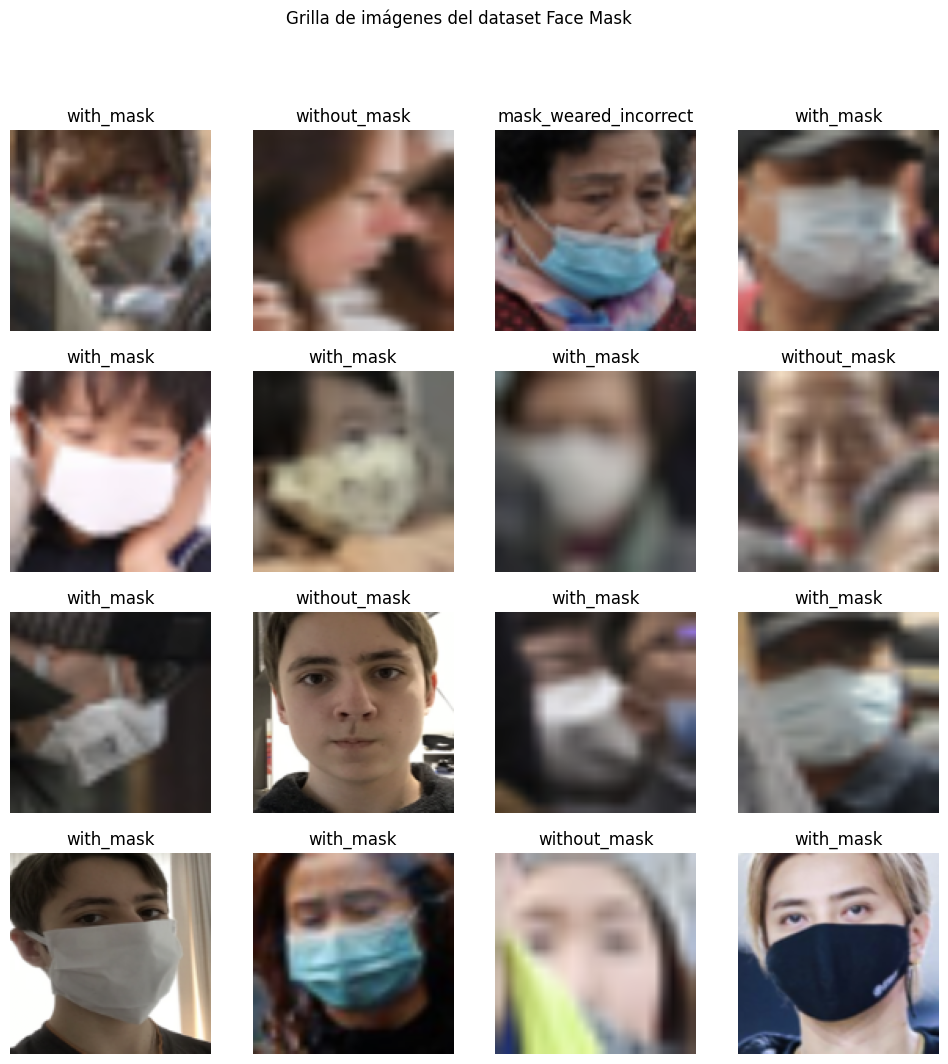

In [107]:
# Extraemos las imagenes y las aplanamos, verificamos despues que existan todas (4072)

# Función para cargar, redimensionar (sin importar si es más grande o más chica) y aplanar
def cargar_y_aplanar_imagenes(image_path, target_size=(128, 128)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)  # redimensiona siempre a target_size
    img = img / 255.0  # Normalizar a [0, 1]
    return img

# Ruta base donde están las carpetas por categoría
ruta_base = base_dir / "Dataset" / "images_processed"

imagenes = []
etiquetas = []

# Recorremos cada carpeta (cada clase)
for clase in os.listdir(ruta_base):
    carpeta_clase = os.path.join(ruta_base, clase)
    if not os.path.isdir(carpeta_clase):
        continue
    
    # Recorremos cada imagen dentro de la carpeta
    for archivo in os.listdir(carpeta_clase):
        if archivo.lower().endswith('.png'):
            ruta_img = os.path.join(carpeta_clase, archivo)
            imagenes.append(cargar_y_aplanar_imagenes(ruta_img))
            etiquetas.append(clase)  # nombre de la carpeta como etiqueta

# Convertimos a tensores/arrays
imagenes = tf.stack(imagenes)  # (num_imagenes, 128*128*3)
etiquetas = np.array(etiquetas)

# Se visualiza ejemplo de imagenes
plot_samples_dataset(imagenes, etiquetas)


In [108]:
# Codificamos las etiquetas a números
le = LabelEncoder()
etiquetas_num = le.fit_transform(etiquetas)

# Mostramos info de las clases
for i, clase in enumerate(le.classes_):
    print(f"{clase} : {i}")

# Conteo de elementos por clase
clases, conteos = np.unique(etiquetas_num, return_counts=True)
for clase, conteo in zip(clases, conteos):
    print(f"Clase {clase}: {conteo} elementos")

print(f"Total imágenes cargadas: {len(imagenes)}")

mask_weared_incorrect : 0
with_mask : 1
without_mask : 2
Clase 0: 123 elementos
Clase 1: 3232 elementos
Clase 2: 717 elementos
Total imágenes cargadas: 4072


C:\Users\dgarcia01\AppData\Local\Temp\ipykernel_16952\579922910.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=etiquetas_num, palette='Set1')


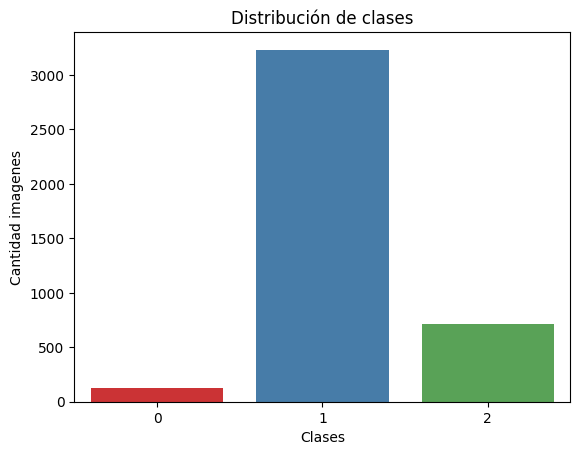

In [109]:
sns.countplot(x=etiquetas_num, palette='Set1')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad imagenes')
plt.show()

#### 2- Creación del modelo

In [110]:
imagenes_tensor = tf.convert_to_tensor(imagenes)

X_train, X_test, y_train, y_test = train_test_split(
    imagenes_tensor.numpy(), etiquetas_num, test_size=0.2, random_state=42, stratify=etiquetas_num)

n_muestras_train = X_train.shape[0]
n_muestras_test = X_test.shape[0]
dim_imagen = (128, 128)
n_canales = 3

print(f"\nTamaño de datos de entrenamiento: {n_muestras_train}")
contador_train = Counter(y_train)
for clase, cantidad in contador_train.items():
    print(f"Clase {clase}: {cantidad} imagenes")

print('Dimensión X_train: {}'.format(X_train.shape))
print('Dimensión X_test: {}'.format(X_test.shape))


Tamaño de datos de entrenamiento: 3257
Clase 1: 2585 imagenes
Clase 2: 574 imagenes
Clase 0: 98 imagenes
Dimensión X_train: (3257, 128, 128, 3)
Dimensión X_test: (815, 128, 128, 3)


In [111]:
# Split del conjunto de train en train y validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2, random_state=42, stratify=y_train
)

In [112]:
y_train_onehot = to_categorical(y_tr, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_train_onehot))
train_dataset = train_dataset.shuffle(buffer_size=len(X_tr)).batch(32, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_onehot)).batch(32, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot)).batch(32, drop_remainder=True)

In [113]:
# CNN
def cnn_model(input_shape, num_classes):
    # Definir la entrada
    inputs = tf.keras.Input(shape=input_shape)

    # Primera capa convolucional y de pooling
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                               strides=(1, 1),
                               padding="valid")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Segunda capa convolucional y de pooling
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu",
                               strides=(1, 1),
                               padding="valid")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Aplanar y añadir Dropout
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Capa de salida
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Crear el modelo usando la API funcional
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_keras')

    return model

In [114]:
# Ahora se definen los input shape y el numero de clases
input_shape = (dim_imagen[0], dim_imagen[1], n_canales)
num_classes = 3

# Crear el modelo cnn
cnn_keras = cnn_model(input_shape, num_classes)

# Visualizar el resumen del modelo
cnn_keras.summary()

Model: "cnn_keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       172,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,195 (750.76 KB)

 Trainable params: 192,195 (750.76 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
# Compilar el modelo
cnn_keras.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
            optimizer=SGD(),
            metrics=['accuracy'])


# Entrenar el modelo
history = cnn_keras.fit(X_tr, y_train_onehot,
                    epochs=30,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - accuracy: 0.7854 - loss: 0.5962 - val_accuracy: 0.7781 - val_loss: 0.5405
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 348ms/step - accuracy: 0.8679 - loss: 0.4606 - val_accuracy: 0.8656 - val_loss: 0.4447
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.9217 - loss: 0.3957 - val_accuracy: 0.8953 - val_loss: 0.4041
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.9332 - loss: 0.3725 - val_accuracy: 0.9109 - val_loss: 0.3854
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.9359 - loss: 0.3616 - val_accuracy: 0.9187 - val_loss: 0.3774
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.9359 - loss: 0.3534 - val_accuracy: 0.9219 - val_loss: 0.3722
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.9370 - loss: 0.3483 - val_accuracy: 0.9266 - val_loss: 0.3656
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.9390 - loss: 0.3432 - val_accu

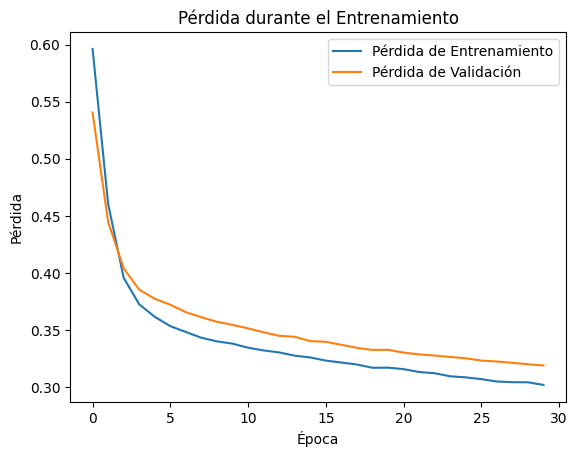

In [116]:
plot_loss_historia_keras(history)

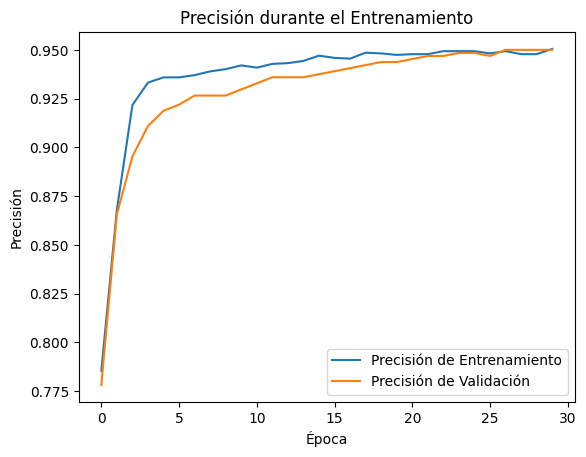

In [117]:
plot_acc_historia_keras(history)

In [118]:
score = cnn_keras.evaluate(X_test, y_test_onehot, batch_size=32)

score

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9387 - loss: 0.3342


[0.3342157006263733, 0.9386503100395203]

In [119]:
# Realizar predicciones en el conjunto de prueba
y_pred = cnn_keras.predict(X_test)

# Convertir las predicciones en etiquetas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test_onehot.astype(int)  # Las etiquetas reales del conjunto de prueba

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Reporte de Clasificación para el CNN de facemask:

              precision    recall  f1-score   support

           0       0.83      0.20      0.32        25
           1       0.96      0.97      0.97       647
           2       0.84      0.93      0.88       143

    accuracy                           0.94       815
   macro avg       0.88      0.70      0.72       815
weighted avg       0.94      0.94      0.93       815



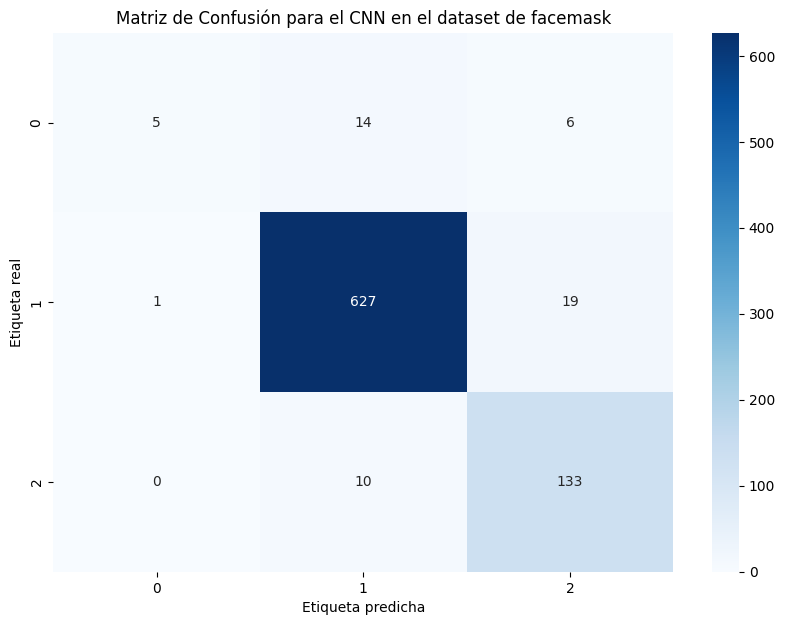

In [120]:
# Generar el reporte de clasificación
print("Reporte de Clasificación para el CNN de facemask:\n")
y_true_labels = np.argmax(y_true, axis=1)
print(classification_report(y_true_labels, y_pred_classes))

# Crear la matriz de confusión
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Visualizar la matriz de confusión usando Seaborn
plot_matriz_confusion(cm, "CNN")